In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.opengl)

N = 256
M = 512

def WaveIteration(u, v, dt):
    i,j = u.indices
    laplacian = u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1] - u[i,j] * 4.0
    force = laplacian - 0.1 * tf.sin(2.0*np.pi*u)
    v_new = v + dt*force
    u_new = u + dt*v_new
    return u_new, v_new

def WaveEq():
    u = tf.input([-1, -1], tf.float32)
    v = tf.input(u.shape, tf.float32)

    return WaveIteration(u, v, 0.2)

test = tf.compile(WaveEq)


TensorFrost module loaded!
WaveEq:
  Kernel count: 1
  Intermediate buffers: 0
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 483
  IR Compile time: 3.504200 ms
  Steps time: 1618.466064 ms



In [2]:
print(test.list_operations())

List of operations:
int v1_0 = input_shape(cost=0.000000, )
int v1_1 = input_shape(cost=0.000000, )
float u = memory(memory_type=input, cost=0.000000, shape=[v1_0,v1_1], )
float v = memory(memory_type=input, cost=0.000000, shape=[v1_0,v1_1], )
float v_new = memory(memory_type=output, cost=0.000000, modified, shape=[v1_0,v1_1], )
float m0 = memory(memory_type=output, cost=0.000000, modified, shape=[v1_0,v1_1], )
kernel(cost=0.000000, shape=[v1_0,v1_1], )
{
  int v2_0 = block_id(cost=0.000000, shape=[v1_0,v1_1], )
  int v2_3 = block_thread_id(data=[1], cost=0.000000, shape=[v1_0,v1_1], )
  int v2_4 = block_thread_id(data=[0], cost=0.000000, shape=[v1_0,v1_1], )
  int v2_5 = add(inputs=[v1_1,v2_2(16)], cost=1.000000, )
  int v2_7 = sub(inputs=[v2_5,v2_6(1)], cost=2.000000, )
  int blocks_shape_1 = div(inputs=[v2_7,v2_2(16)], cost=4.000000, )
  int v2_8 = div(inputs=[v2_0,blocks_shape_1], cost=6.000000, shape=[v1_0,v1_1], )
  int v2_9 = mul(inputs=[v2_8,blocks_shape_1], cost=11.000000, sha

In [2]:
#do a few steps and measure performance by timing every 100 steps
import time
import imageio
from IPython.display import Image
import os

start = time.time()

file_path = 'H:/TestVideos/wave.gif'

#remove file if it exists

if os.path.isfile(file_path):
    os.remove(file_path)

writer = imageio.get_writer(file_path, mode='I', fps=30, loop=0)

x = np.arange(M)
y = np.arange(N)
X,Y = np.meshgrid(x, y)
Anp = np.exp(-((X-M/2)**2 + (Y-N/2+50)**2)/(10**2))
Anp += np.exp(-((X-M/2-50)**2 + (Y-N/2-50)**2)/(10**2))
Bnp = np.zeros((N, M))

A = tf.tensor(Anp)
B = tf.tensor(Bnp)

iters = 1500

for i in range(iters):
    A, B = test(A, B)
    if(i % 50 == 0):
        frame = A.numpy
        frame = np.clip(np.abs(3.0 * frame * 255), 0, 255).astype(np.uint8)
        writer.append_data(frame)
    if i % 100 == 99:
        print("Iterations per second: " + str(100/(time.time()-start)))
        start = time.time()


writer.close()

Iterations per second: 1307.2313263976762
Iterations per second: 14287.723123041287
Iterations per second: 10525.493738864212
Iterations per second: 10000.486397558476
Iterations per second: 11763.908677848207
Iterations per second: 9999.771123402632
Iterations per second: 14285.290010558223
Iterations per second: 12500.533484338212
Iterations per second: 10526.55038273309
Iterations per second: 11764.898600319766
Iterations per second: 11110.444756430294
Iterations per second: 15385.166165358374
Iterations per second: 12500.160934612863
Iterations per second: 15385.166165358374
Iterations per second: 10526.286201877227


C:\Users\micha\AppData\Local\Temp\ipykernel_94420\2846262413.py:34: RuntimeWarning: overflow encountered in multiply
  frame = np.clip(np.abs(3.0 * frame * 255), 0, 255).astype(np.uint8)
C:\Users\micha\AppData\Local\Temp\ipykernel_94420\2846262413.py:34: RuntimeWarning: invalid value encountered in cast
  frame = np.clip(np.abs(3.0 * frame * 255), 0, 255).astype(np.uint8)


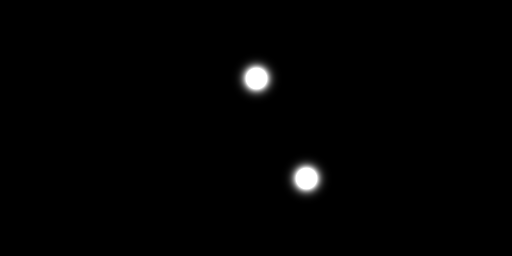

In [4]:
#display the gif
Image(filename=file_path)

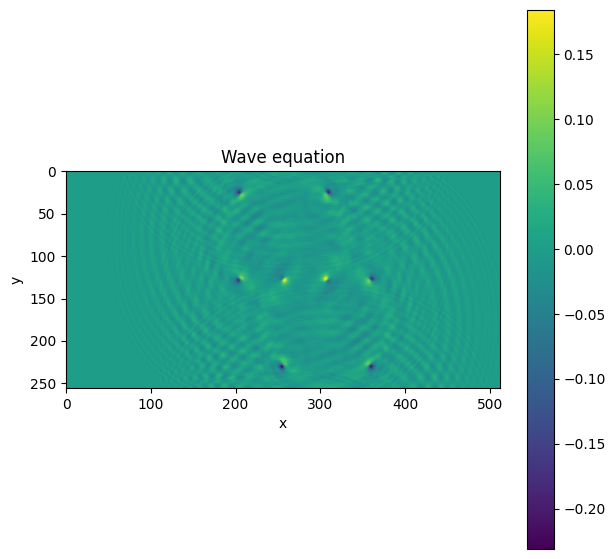

In [5]:
# Plot the results (with colorbar)
plt.figure(figsize=(7,7))
plt.imshow(A.numpy)
plt.colorbar()
plt.title("Wave equation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()